In order to run this program, you must convert the file to a .wav file by another means. There are other websites that can do this for you. I used [Convertio](https://convertio.co/mp4-wav/) but there are others you can use.

To upload your .wav file, click on the folder icon to the left and then the page with an arrow in the extended tab.

After that, customize the variables in the [Variable Toggles](#cell-id) panel. You must change the filePath variable to the location of the file you uploaded.

Once all the variables are how you want, use the runtime tab at the top of the screen and Run All

Scroll down till you get to the graph


In [1]:
from scipy import fft, arange
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import yticks
from scipy.io import wavfile
import os
import math

# 3/19:
# https://www.dataq.com/data-acquisition/general-education-tutorials/fft-fast-fourier-transform-waveform-analysis.html#:~:text=Therefore%2C%20with%20an%20FFT%20you,%2C%20or%202048%20points%2C%20etc.
# FFT should have 2^n data points
# DFT is not restricted by this but is slower
# On both, end points of sine wave should match
# How to do?
#    Before FFT, take points 1 and 2^n and find the difference
#      Compare this difference to the surrounding points 2, 2^n + 1 and so on
#      Take the smallest difference, must be within a few points

#<a name="cell-id"></a>Variable Toggles

In [2]:
filePath = "/content/Dust in the Wind.wav"
#Go to the file you uploaded,
#hover over it and click on the 3 vertical dots on the right,
#then copy path. Paste that in the string(Red text with quotes) above

  #Frequency ranges to analyze, select 1 of them
#Selecting a accurate range improves the final graph
FrequencyOption = 3

# G to E 8th (Default)
lowfrq = 180
highfrq = 1500

if(FrequencyOption == 1): # G to E 4th
  lowfrq = 180
  highfrq = 1000

if(FrequencyOption == 2): # G to E
  lowfrq = 180
  highfrq = 675

if(FrequencyOption == 3): # D to E 4th
  lowfrq = 280
  highfrq = 1000

if(FrequencyOption == 4): # A to E 8th
  lowfrq = 420
  highfrq = 1500

if(FrequencyOption == 5): # Custom
  lowfrq = 180
  highfrq = 675

#Violin: G-string (G3)is ~196, D-string (D4) is ~294
#        A-string (A4) is 440, E-string (E5) is ~659
#        4th finger E-string is 932.3
#        8th finger E-string ~ 1475


  #Selects how many notes are displayed on the final graph for each interval
DisplayLevels = 3
  #Allows for precise time measurements if set to True else False
EnableTimeSelection = True
BeginTime = 0
EndTime = 15
# Time is in seconds

  # Minimum decibel to qualify as sound to analyze
dbCutoff = 30
ampCutoff = 10**(dbCutoff/20)



#Prefer to keep everything below the way it is

Color_Code = ['maroon', 'white', 'tan', 'gold', 'white', 'forestgreen', 'white', 'aquamarine', 'lightskyblue', 'white', 'violet','white']

  #How many intervals per second (10)
perSec = 10

  #Set up variables
sr, signal = wavfile.read(filePath)
rate = sr//perSec
DurationInSec = len(signal)/sr

#Initializing code

###Builds constant array for frequency of notes and a dictionary of the frequency and note's letter

In [3]:
#List of frequencies of notes
Octave_Frequencies = [0]
Notes = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
#Dictionary relating frequencies to their respective letters
AutoTone = {0:"_"}

#Range(12*4+1) goes from A1 to A7
for i in range(12*6+1):
  frequency = 55 * 2**(i/12)
  Octave_Frequencies.append(frequency)

  note = Notes[i%12]
  
  octave = (i+9)//12 + 1
  note += str(octave)

  #if(frequency >= 1000):
    #note += "+"

  #AutoTone maps frequency to the note
  AutoTone[frequency] = note

In [4]:
NoteToFrequency = {v: k for k, v in AutoTone.items()}

###Functions

In [5]:
def frequency_sepectrum(x, sf):
  """
  Derive frequency spectrum of a signal from time domain
  :param x: signal in the time domain
  :param sf: sampling frequency
  :returns frequencies and their content distribution
  """
  x = x - np.average(x)  # zero-centering
  
  n = len(x)
  #print(n)
  k = np.arange(n)
  tarr = n / float(sf) #Duration(seconds)
  frqarr = k / float(tarr)  # two sides frequency range

  frqarr = frqarr[range(n // 2)]  # one side frequency range

  x = fft.fft(x) / n  # fft computing and normalization
  x = x[range(n // 2)]

    
  #Added code to trim frequency range
  #high and low frq defined in variable initialization
  
  if(frqarr[-1] > highfrq):
    highIdx = np.where(frqarr > highfrq)[0][0]
  else:
   highIdx = -1
  if(frqarr[0] < lowfrq):
   lowIdx = np.where(frqarr < lowfrq)[0][-1]
  else:
   lowIdx = 0
    
  frqarr = frqarr[lowIdx:highIdx]
  x = x[lowIdx:highIdx]


  return frqarr, abs(x)

In [6]:
def getClosest(val1, val2, target): 
    if (target - val1 >= val2 - target): 
        return val2 
    else: 
        return val1 

In [7]:
def findClosest(target, arr):  
    '''
    Takes a pitch and returns the note related
    '''

    n = len(arr)

    # Corner cases 
    if (target <= arr[0]): 
        return arr[0] 
    if (target >= arr[n - 1]): 
        return arr[n - 1] 
  
    # Doing binary search 
    i = 0; j = n; mid = 0
    while (i < j):  
        mid = int((i + j) / 2)
        
        #print("index", mid, " contains ", arr[mid])

        if (arr[mid] == target): 
            return arr[mid] 
  
        # If target is less than array  
        # element, then search in left 
        if (target < arr[mid]) : 
  
            # If target is greater than previous 
            # to mid, return closest of two 
            if (mid > 0 and target > arr[mid - 1]): 
                return getClosest(arr[mid - 1], arr[mid], target) 
  
            # Repeat for left half  
            j = mid 
          
        # If target is greater than mid 
        else : 
            if (mid < n - 1 and target < arr[mid + 1]): 
                return getClosest(arr[mid], arr[mid + 1], target) 
                  
            # update i 
            i = mid + 1
          
    # Only single element left after search 
    return arr[mid]

In [8]:
def Sort_Double_Array(arr):
  """
  Format of starting array:
  [ ([],[]) ]
  """
  for i in range(len(arr)): #Access each tuple

    for j in range(len(arr[i][1])): #Bubble sort
      for k in range(len(arr[i][1])):
        if(arr[i][1][j] > arr[i][1][k]):
          arr[i][1][j], arr[i][1][k] = arr[i][1][k], arr[i][1][j]
          arr[i][0][j], arr[i][0][k] = arr[i][0][k], arr[i][0][j]

#Main Code

In [9]:
i = 1 #keeps track of which itteration we are on
DbRatio = []
AmpRatio = []

while(i*rate < len(signal)):
  partition = signal[rate*(i-1):rate*i]
  raw_Audio = partition[:, 0]  
  frq, partition_Volume = frequency_sepectrum(raw_Audio, sr)

  if(max(partition_Volume) != 0 and max(raw_Audio) != 0):
    DbRatio.append(max(raw_Audio) / (20 * np.log10(max(partition_Volume))))
    AmpRatio.append( max(raw_Audio) / max(partition_Volume))

  i += 1

In [10]:
DbRatio = np.asarray(DbRatio)
AmpRatio = np.asarray(AmpRatio)

if (np.std(DbRatio) < np.std(AmpRatio)):
  volumeRatio = np.average(DbRatio)
else:
  volumeRatio = np.average(AmpRatio)

In [11]:
# partition -> Breaks down entire signal to sections based on rate
# raw_Audio -> Input audio from the file, I think it's always in amplitude
# frq -> Buckets of frequencies that is defined in frequency_spectrum
# partition_Volume -> Corresponds to how loud each frequency bucket is.
#      Amplitude if original file is recorded from phone, otherwise idk


i = 1
Calculated_Notesv2 = []
while(i*rate < len(signal)):
  Notes_in_partitionv2 = []
  Notes_in_partition_ampv2 = []

  partition = signal[rate*(i-1):rate*i]
  raw_Audio = partition[:, 0]  
  frq, partition_Volume = frequency_sepectrum(raw_Audio, sr)
  partition_Volume *= volumeRatio #Changing ratio to see how amplitude changes
  
  #Take the frequencies that are above the amp cutoff
  arr = np.where(partition_Volume > ampCutoff)[0] #ampCutoff
  
  for j in range(len(arr)):
    arrIdx = arr[j]
    key = AutoTone[findClosest(frq[arrIdx], Octave_Frequencies)]

    if(key not in Notes_in_partitionv2):
      Notes_in_partitionv2.append(key)
      Notes_in_partition_ampv2.append( partition_Volume[arrIdx] )
    else:
      idx = np.where(np.asarray(Notes_in_partitionv2) == key)[0][0]
      if(Notes_in_partition_ampv2[idx] < partition_Volume[arrIdx]):
        Notes_in_partition_ampv2[idx] = partition_Volume[arrIdx]
    
  
  Calculated_Notesv2.append((Notes_in_partitionv2, Notes_in_partition_ampv2))
  
  i += 1

In [12]:
Sort_Double_Array(Calculated_Notesv2) #Organizes notes by loudest to quietest

In [13]:
found_frequencies = []
temp = []
for i in range (len(Calculated_Notesv2)):
  temp.append(len(Calculated_Notesv2[i][0]))
max_depth = max(temp)

for i in range(max_depth): #How many itterations
  temp = []
  for j in range(len(Calculated_Notesv2)): #Runs through entire list
    if(len(Calculated_Notesv2[j][0]) >= (i+1)):
      temp.append(NoteToFrequency[ Calculated_Notesv2[j][0][i] ])
    else:
      temp.append(-1)
  found_frequencies.append(temp)

In [14]:
xIntervals = np.arange(0, len(found_frequencies[0])/10, 0.1)

#Output

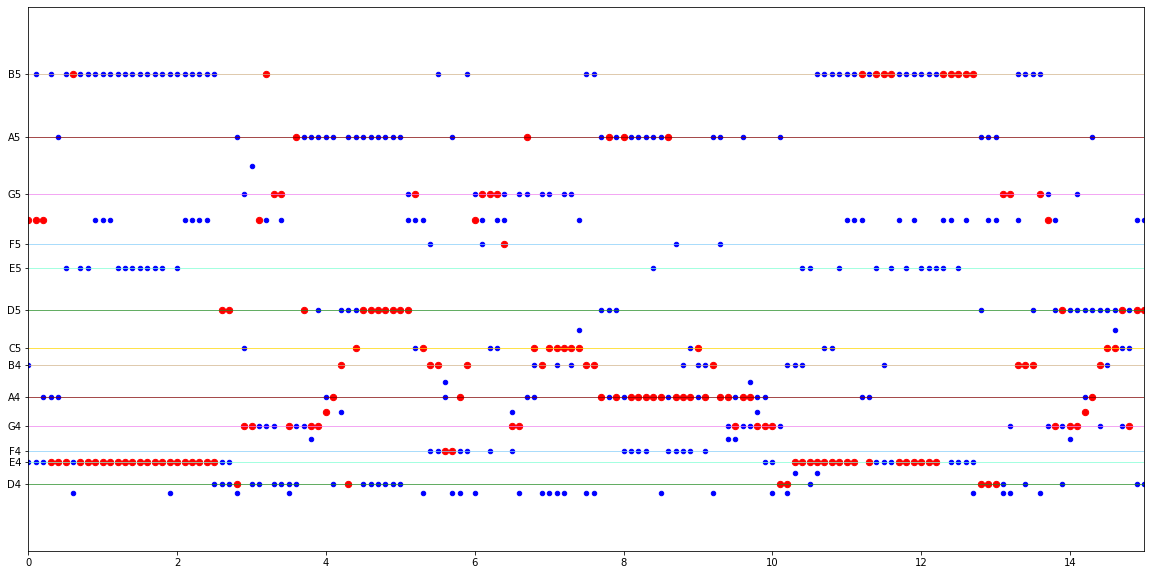

In [15]:
plt.figure(figsize=(20,10))
FrequenciesInRange = []
NotesInRange = []

for i in range(len(Octave_Frequencies)): #Draws lines for non-sharp notes
  val = i%12 #12 notes in an octave
  if(val==2 or val==5 or val==7 or val==10 or val==0): #Takes out all sharp notes and silent notes
    continue
  if(Octave_Frequencies[i] < lowfrq or Octave_Frequencies[i] > highfrq):
    continue
  if(val==1 or val==3 or val==4 or val==6 or val==8 or val==9 or val==11):
    plt.plot([0,math.ceil(DurationInSec)], [Octave_Frequencies[i],Octave_Frequencies[i]], Color_Code[val-1], linewidth = .7) #here
    FrequenciesInRange.append(Octave_Frequencies[i])

for i in range(len(FrequenciesInRange)):
  NotesInRange.append(AutoTone[FrequenciesInRange[i]])

for i in range(len(found_frequencies)): #Places dots for volume at each interval
  if (i == DisplayLevels): #How many levels should be shown
    break
  if(i==0):
    plt.scatter(xIntervals, found_frequencies[i],s=40, c='r') #here
  else:
    plt.scatter(xIntervals, found_frequencies[i],s=20, c='b') #here


yticks(FrequenciesInRange, NotesInRange)
if(EnableTimeSelection):
  plt.axis([BeginTime,EndTime, (lowfrq-100), (highfrq+100)])
else:
  plt.axis([0,math.ceil(DurationInSec), (lowfrq-100), (highfrq+100)])

plt.show()
#Violin: G-string (G3)is ~196, D-string (D4) is ~294
#        A-string (A4) is 440, E-string (E5) is ~659
#        4th finger E-string (B5)is 932.3
#        E-string 5th note (C6)

The red dots are the loudest note being played during that interval and the blue ones are all the rest.

Notes in between lines are sharps/flats

*   Violet = G
*   Light sky blue = F
*   Aquamarine = E
*   Forestgreen = D
*   Gold = C
*   Tan = B
*   Maroon = A

A5 = 880

A4 = 440

A3 = 220

[Curious what this does?](https://www.youtube.com/watch?v=dQw4w9WgXcQ)

#Testing to make lines equal dististance

In [16]:
log_found_frequencies = []
for i in range(len(found_frequencies)):
  temp = []
  for j in range(len(found_frequencies[i])):

    if(found_frequencies[i][j] <= 0):
      temp.append(found_frequencies[i][j])
      continue

    temp.append(math.log(found_frequencies[i][j]))
  log_found_frequencies.append(temp)

In [17]:
log_FrequenciesInRange = []
for i in range(len(FrequenciesInRange)):
  log_FrequenciesInRange.append(math.log(FrequenciesInRange[i]))

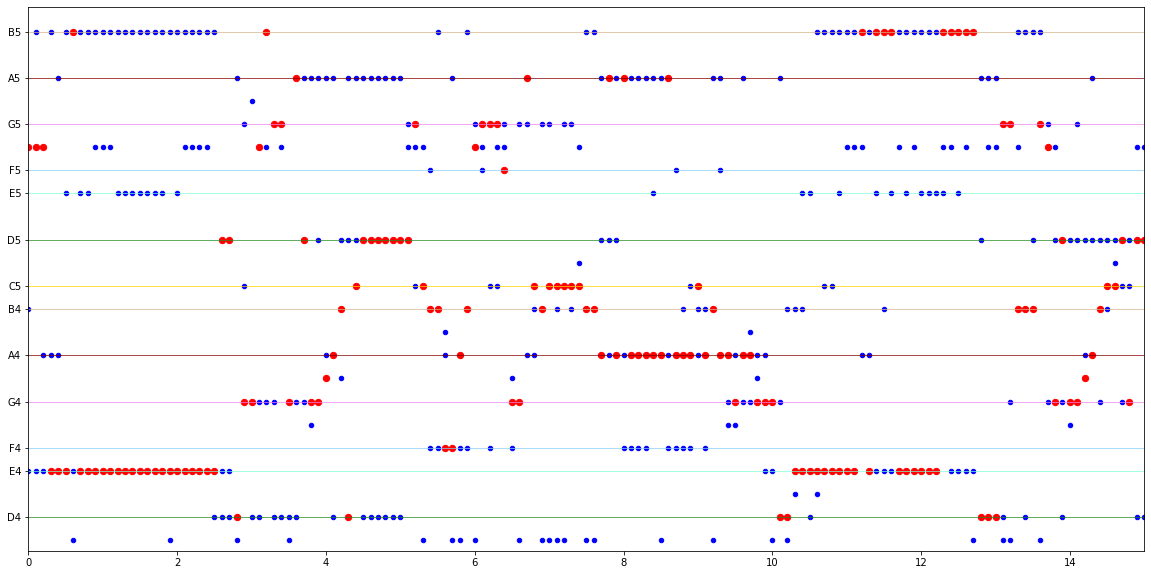

In [18]:
plt.figure(figsize=(20,10))
FrequenciesInRange = []
NotesInRange = []

for i in range(len(Octave_Frequencies)): #Draws lines for non-sharp notes
  val = i%12 #12 notes in an octave
  if(val==2 or val==5 or val==7 or val==10 or val==0): #Takes out all sharp notes and silent notes
    continue
  if(Octave_Frequencies[i] < lowfrq or Octave_Frequencies[i] > highfrq):
    continue
  if(val==1 or val==3 or val==4 or val==6 or val==8 or val==9 or val==11):
    plt.plot([0,math.ceil(DurationInSec)], 
             [math.log(Octave_Frequencies[i]),math.log(Octave_Frequencies[i])],
             Color_Code[val-1], linewidth = .7) #here
    FrequenciesInRange.append(Octave_Frequencies[i])

for i in range(len(FrequenciesInRange)):
  NotesInRange.append(AutoTone[FrequenciesInRange[i]])
  #log here?

for i in range(len(found_frequencies)): #Places dots for volume at each interval
  if (i == DisplayLevels): #How many levels should be shown
    break
  if(i==0):
    plt.scatter(xIntervals, log_found_frequencies[i],s=40, c='r') #Need to use log on each individual
  else:
    plt.scatter(xIntervals, log_found_frequencies[i],s=20, c='b') #here


yticks(log_FrequenciesInRange, NotesInRange)
if(EnableTimeSelection):
  #plt.axis([BeginTime,EndTime, (lowfrq-100), (highfrq+100)]) #Changing
  if(lowfrq-10 < 0):
    lowfrq = 10
  plt.axis([BeginTime,EndTime, math.log(lowfrq-10), math.log(highfrq+50)]) #Changing
else:
  plt.axis([0,math.ceil(DurationInSec), math.log(lowfrq-10), math.log(highfrq+100)])

plt.show()
#Violin: G-string (G3)is ~196, D-string (D4) is ~294
#        A-string (A4) is 440, E-string (E5) is ~659
#        4th finger E-string (B5)is 932.3